# Time series forecasting with `Darts`

## The `TimeSeries` object

`TimeSeries` is the main abstraction provided by `Darts`. It is meant to be immutable.

`Darts` supports both univariate and multivariate `TimeSeries`.

Internally, the data is stored in a `pandas.DataFrame`, and many of the usual methods available on `DataFrame` are too on `TimeSeries`.

### Notebook setup (not relevant to darts in particular)

In [2]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

### Usual imports

In [3]:
import numpy as np
import pandas as pd

from darts import TimeSeries

### Creating a `TimeSeries`

In [4]:
# from a DataFrame, itself created by reading a CSV file
df = pd.read_csv('AirPassengers.csv', delimiter=",")
air_series = TimeSeries.from_dataframe(df, time_col='Month', value_cols=['#Passengers'])

# using TimeSeries generation functions
from darts.utils.timeseries_generation import constant_timeseries, linear_timeseries, sine_timeseries, random_walk_timeseries

const_series = constant_timeseries(length=50, value=5)
lin_series = linear_timeseries(length=50, start_value=0, end_value=10)
sine_series = sine_timeseries(length=50, value_frequency=0.05, value_amplitude=2, value_y_offset=5)
random_series = random_walk_timeseries(length=50, std=0.25)

### Printing and plotting

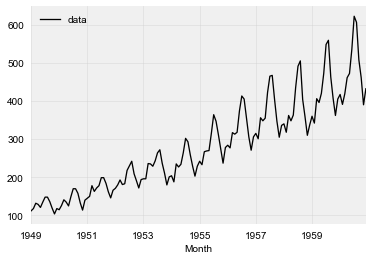

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
...                 ...
1960-08-01          606
1960-09-01          508
1960-10-01          461
1960-11-01          390
1960-12-01          432

[144 rows x 1 columns]
Freq: MS


In [5]:
# plotting
import matplotlib.pyplot as plt

air_series.plot(label='data')

plt.legend()
plt.show()

# printing
print(air_series)

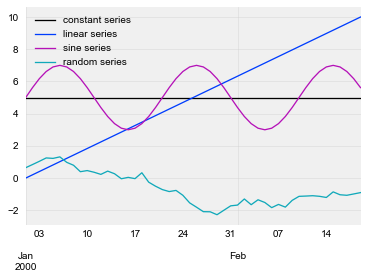

In [6]:
const_series.plot(label="constant series")
lin_series.plot(label="linear series")
sine_series.plot(label="sine series")
random_series.plot(label="random series")

plt.legend()
plt.show()

### Util methods on `TimeSeries`
* `+`, `-`, `len()`, `==`, …
* `stack()`
* `map()`
* `resample()`
* `add_datetime_attribute()` and `add_holidays()`

And many others

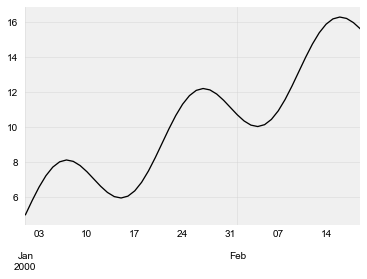

In [7]:
# Add two series together (elementwise)
combined_series = lin_series + sine_series
combined_series.plot()

plt.show()

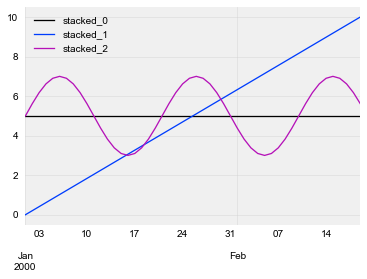

            0          1         2
2000-01-01  5   0.000000  5.000000
2000-01-02  5   0.204082  5.618034
2000-01-03  5   0.408163  6.175571
2000-01-04  5   0.612245  6.618034
2000-01-05  5   0.816327  6.902113
2000-01-06  5   1.020408  7.000000
2000-01-07  5   1.224490  6.902113
2000-01-08  5   1.428571  6.618034
2000-01-09  5   1.632653  6.175571
2000-01-10  5   1.836735  5.618034
2000-01-11  5   2.040816  5.000000
2000-01-12  5   2.244898  4.381966
2000-01-13  5   2.448980  3.824429
2000-01-14  5   2.653061  3.381966
2000-01-15  5   2.857143  3.097887
2000-01-16  5   3.061224  3.000000
2000-01-17  5   3.265306  3.097887
2000-01-18  5   3.469388  3.381966
2000-01-19  5   3.673469  3.824429
2000-01-20  5   3.877551  4.381966
2000-01-21  5   4.081633  5.000000
2000-01-22  5   4.285714  5.618034
2000-01-23  5   4.489796  6.175571
2000-01-24  5   4.693878  6.618034
2000-01-25  5   4.897959  6.902113
2000-01-26  5   5.102041  7.000000
2000-01-27  5   5.306122  6.902113
2000-01-28  5   5.51

In [8]:
# Create a multivariate TimeSeries from other TimeSeries
stacked_series = const_series.stack(lin_series).stack(sine_series)
stacked_series.plot(label="stacked")

plt.legend()
plt.show()

print(stacked_series)

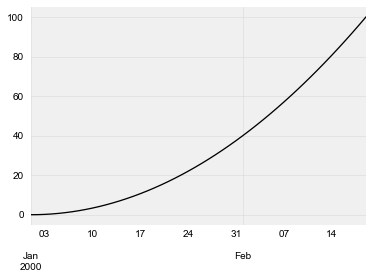

In [9]:
# Apply a function elementwise (map)
squared_series = lin_series.map(lambda x: x**2)
squared_series.plot()

### Indexing

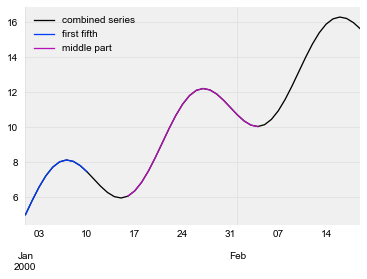

In [10]:
# Slice using indices
first_fifth = combined_series[:10]
middle_part = combined_series[15:35]

combined_series.plot(label="combined series")
first_fifth.plot(label="first fifth")
middle_part.plot(label="middle part")

plt.legend()
plt.show()

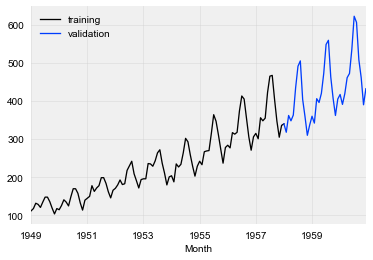

In [19]:
# Slice using pandas.Timestamp
air_series_train, air_series_val = air_series[:pd.Timestamp('1958-01-01')], air_series[pd.Timestamp('1958-01-01'):]
air_series_train.plot(label="training")
air_series_val.plot(label="validation")

plt.legend()
plt.show()

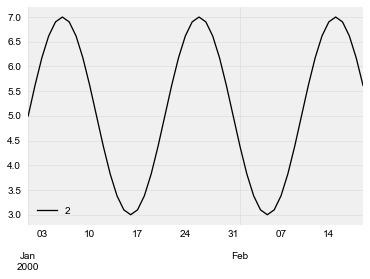

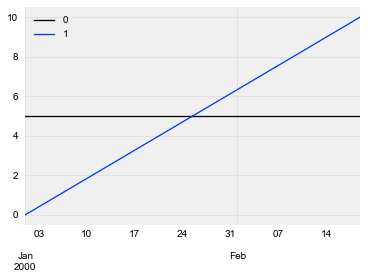

In [20]:
# get a subset of a multivariate TimeSeries
stacked_2 = stacked_series['2']
stacked_2.plot()

plt.legend()
plt.show()

stacked_01 = stacked_series[['0', '1']]
stacked_01.plot()

plt.legend()
plt.show()

### Statistics

Is lin_series seasonal ? False


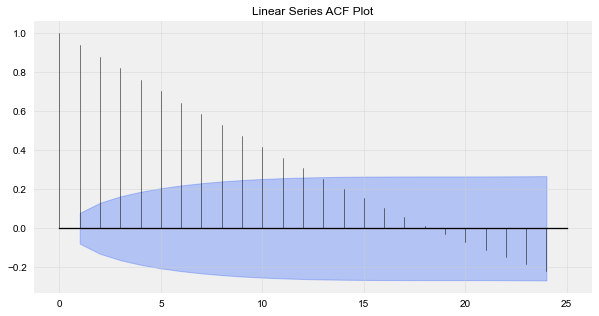

In [21]:
# Check for seasonality
from darts.utils.statistics import check_seasonality, plot_acf

is_seasonal, period = check_seasonality(lin_series)
print("Is lin_series seasonal ? {}".format(is_seasonal))

plot_acf(lin_series, title="Linear Series ACF Plot")

Is the AirPassenger series seasonal ? True, period 12


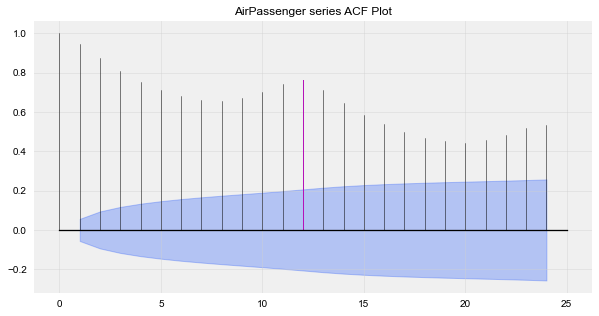

In [22]:
is_seasonal, period = check_seasonality(air_series)
print("Is the AirPassenger series seasonal ? {}, period {}".format(is_seasonal, period))

plot_acf(air_series, period, title="AirPassenger series ACF Plot")

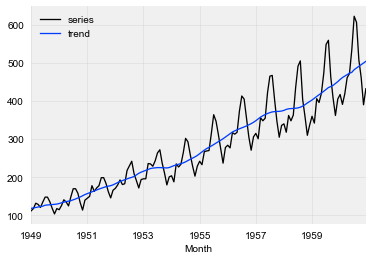

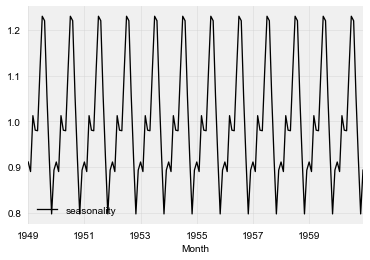

In [23]:
# Extract trend and seasonality components of a TimeSeries
from darts.utils.statistics import extract_trend_and_seasonality

trend, seasonality = extract_trend_and_seasonality(air_series)

air_series.plot(label="series")
trend.plot(label="trend")

plt.legend()
plt.show()

seasonality.plot(label="seasonality")
plt.legend()
plt.show()

## `ForecastingModel`

`Darts` provides multiple forecasting models to choose from, and a single unified interface to interact with all of them easily.

### General interface: `fit()` and `predict()`

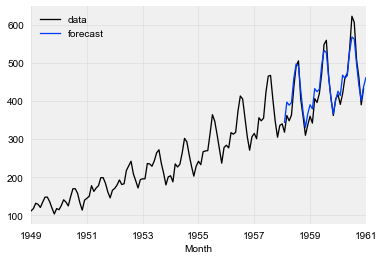

In [24]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(air_series_train)
forecast = model.predict(n=36)

air_series.plot(label="data")
forecast.plot(label="forecast")

plt.legend()
plt.show()

### Backtesting

`backtest()` allows to simulate how the model would have performed if it had been used historically to make predictions

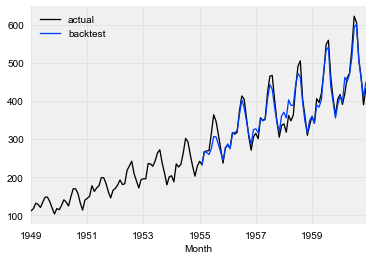

In [25]:
# Make a forecast of 3 months into the future every month, starting from half of the series
backtest = model.backtest(air_series, start=0.5, forecast_horizon=3, stride=1)

air_series.plot(label="actual")
backtest.plot(label="backtest")

plt.legend()
plt.show()

### Hyperparameters tuning

Forecasting models allow to perform gridsearch to find optimal values for their hyperparameters.

Here's an illustration with the `Theta` forecasting model, which has 3 hyperparameters: `theta`, `seasonality_period` and `season_mode`

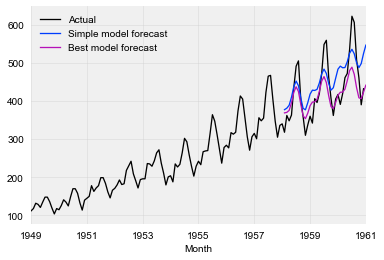

In [32]:
from darts.models import FFT
from darts.metrics import smape

params_dict = {
    'nr_freqs_to_keep': [5, 10, 15],
    'trend': ['poly', 'exp'],
    'trend_poly_degree': [1, 2, 3]
}

best_model = FFT.gridsearch(parameters=params_dict, training_series=air_series_train, val_target_series=air_series_val)
best_model.fit(air_series_train)
best_forecast = best_model.predict(36)

simple_model = FFT(trend='poly')
simple_model.fit(air_series_train)
simple_forecast = simple_model.predict(36)

air_series.plot(label="Actual")
simple_forecast.plot(label="Simple model forecast")
best_forecast.plot(label="Best model forecast")

plt.legend()
plt.show()

### Note: Multivariate Time Series

### `TorchForecastingModel` reproducibility
* `random_state` and `untrained_model()`

### `UnivariateForecastingModel` and `MultivariateForecastingModel`

## Metrics

## `RegressionModel`

### General interface: `fit()` and `predict()`

### Backtesting*

* Actually, do we want to keep that now that we have `RegressionEnsembleModel` ?

## `EnsembleModel`
* A special kind of `ForecastingModel`

### `RegressionEnsembleModel`

## Data (pre) processing

### `DataTransformer`
* Abstraction
* Base classes:
    * `BaseDataTransformer`
    * `FittableDataTransformer`
    * `InvertibleDataTransformer`

### Concrete implementations
* `MissingValuesFiller`
* `Scaler`
* `Mapper` and `InvertibleMapper`
* `BoxCox`

### `Pipeline`